In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("examples/")

# Загрузка и предобработка данных

In [3]:
prices = pd.read_csv('factors/usa/close_price.csv', index_col=0, parse_dates=True)
prices = prices.replace(0, np.nan)

In [4]:
universe = pqr.Universe(prices)
universe.filter(prices > 10)

preprocessor = [
    pqr.Filter(universe.mask),
    pqr.LookBackPctChange(12),
    pqr.Hold(12),
]
momentum = pqr.Factor(prices, "more", preprocessor)
momentum.values = momentum.values.replace(0, np.nan)  # костыль,т.к. в данных есть проблемы

benchmark = pqr.Benchmark.from_universe(universe)

# Строим time-series факторную модель

In [5]:
fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.TimeSeries(min_threshold=0),
        pqr.fm.TimeSeries(max_threshold=-0)
    ],
    allocation_strategy=pqr.EqualWeights()
)

portfolios = fm(momentum, universe)

,Winners,Losers
"Mean Return, %",0.61,0.38
"Volatility, %",3.64,3.75
Sharpe Ratio,0.58,0.35
"Mean Excess Return, %",1.21,-1.52
"Alpha, %",1.31** (2.17),-1.03 (-1.06)
Beta,0.98,0.92


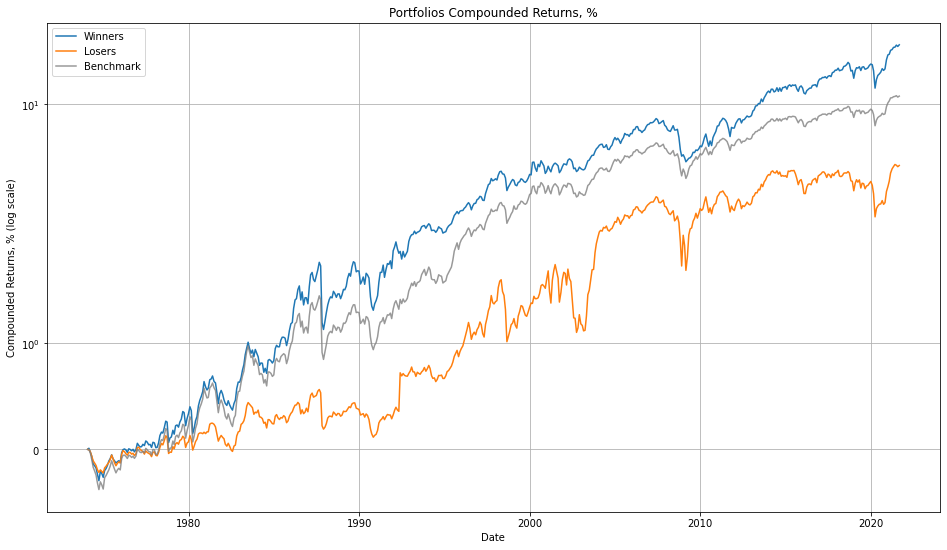

In [6]:
summary = pqr.dash.Dashboard(
    pqr.dash.Table(
        pqr.metrics.MeanReturn(annualizer=1),
        pqr.metrics.Volatility(annualizer=1),
        pqr.metrics.SharpeRatio(rf=0),
        pqr.metrics.MeanExcessReturn(benchmark),
        pqr.metrics.Alpha(benchmark, statistics=True),
        pqr.metrics.Beta(benchmark),
    ),
    pqr.dash.Graph(pqr.metrics.CompoundedReturns(), benchmark=benchmark, figsize=(16, 9), log_scale=True),
)
summary(portfolios)

# Строим quantile факторную модель с 5 квантилями

,Winners,Neutral 1,Neutral 2,Neutral 3,Losers
"Mean Return, %",0.60,0.64,0.59,0.44,0.40
"Volatility, %",4.45,3.45,3.18,3.25,4.73
Sharpe Ratio,0.47,0.64,0.64,0.47,0.29
"Mean Excess Return, %",1.25,1.66,1.08,-0.67,-1.19
"Alpha, %",0.40 (0.40),2.25*** (3.17),2.10*** (3.15),0.42 (0.53),-1.67 (-1.16)
Beta,1.14,0.90,0.83,0.82,1.08


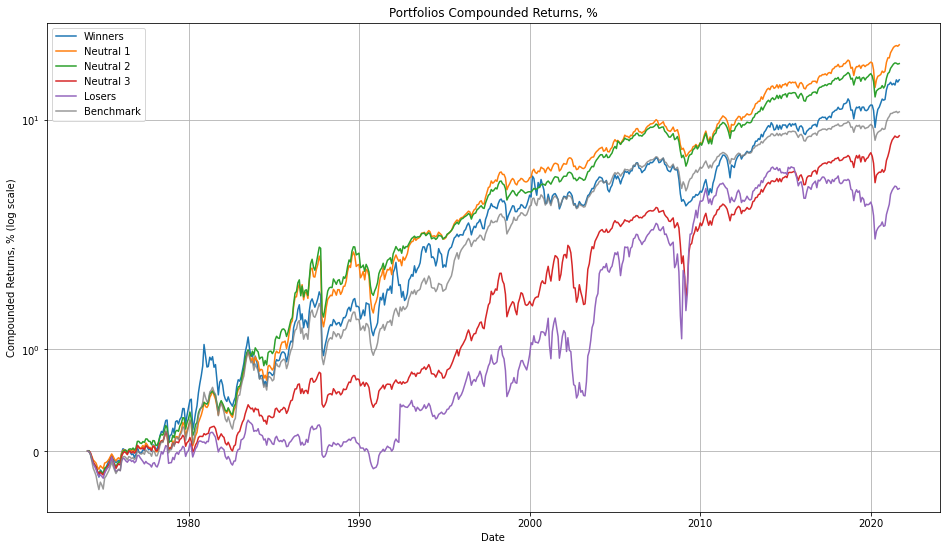

In [7]:
fmq = pqr.fm.FactorModel(
    picking_strategies=pqr.fm.split_quantiles(5),
    allocation_strategy=pqr.EqualWeights(),
)

portfolios_q = fmq(momentum, universe)

summary(portfolios_q)

# Пробуем prophet_test

Дисклеймер: тут что-то забаговало, буду разбираться

No handles with labels found to put in legend.


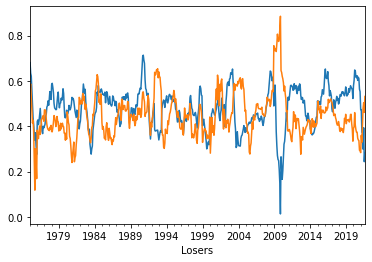

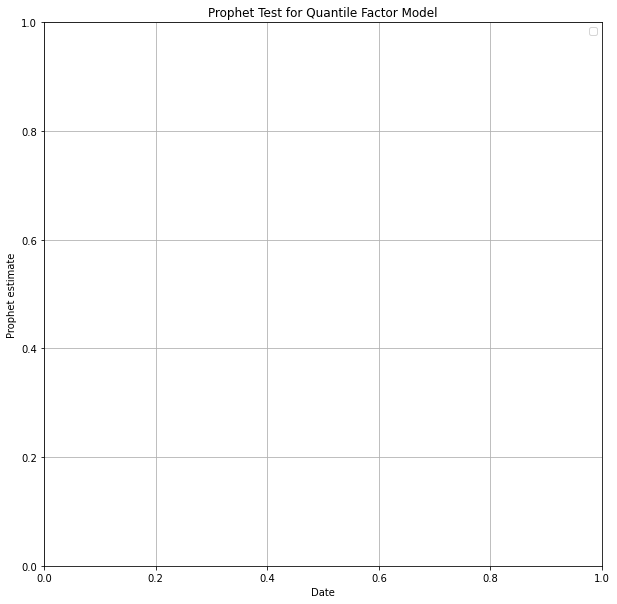

In [8]:
prophet = pqr.tests.OpportunitiesTest(
    universe,
    pqr.EqualWeights(),
    pqr.metrics.TrailingMeanReturn()
)

plt.figure(figsize=(10, 10))

prophet(portfolios_q[0]).plot(label=portfolios_q[0].name)
prophet(portfolios_q[-1]).plot(label=portfolios_q[-1].name)

plt.title("Prophet Test for Quantile Factor Model")
plt.xlabel("Date")
plt.ylabel("Prophet estimate")
plt.legend()
plt.grid();

# Double time-series momentum

Сначала строим 2 простых лонг-портфеля. Первый покупает акции, когда индекс растет, второй - **покупает**, когда индекс падает. Потом из них соберем аля-wml, и готово.

In [9]:
_, benchmark_returns = pqr.utils.align(momentum.values, benchmark.returns)
double_ts_longs = pqr.fm.TimeSeries(min_threshold=0)(momentum) & (benchmark_returns > 0)[:, np.newaxis]
double_ts_shorts = pqr.fm.TimeSeries(max_threshold=0)(momentum) & (benchmark_returns < 0)[:, np.newaxis]

double_ts_portfolio = pqr.Portfolio(
    universe,
    longs=double_ts_longs,
    shorts=double_ts_shorts,
    allocation_strategy=pqr.EqualWeights(),
    name="Double TS"
)

/tmp/ipykernel_71349/1637154260.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  double_ts_longs = pqr.fm.TimeSeries(min_threshold=0)(momentum) & (benchmark_returns > 0)[:, np.newaxis]
/tmp/ipykernel_71349/1637154260.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  double_ts_shorts = pqr.fm.TimeSeries(max_threshold=0)(momentum) & (benchmark_returns < 0)[:, np.newaxis]


<AxesSubplot:xlabel='Double TS'>

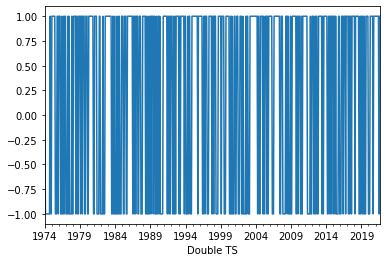

In [10]:
double_ts_portfolio.positions.sum(axis=1).plot()

,Double TS
"Mean Return, %",0.73
"Volatility, %",3.67
Sharpe Ratio,0.69
"Mean Excess Return, %",2.76
"Alpha, %",10.08*** (5.54)
Beta,-0.23


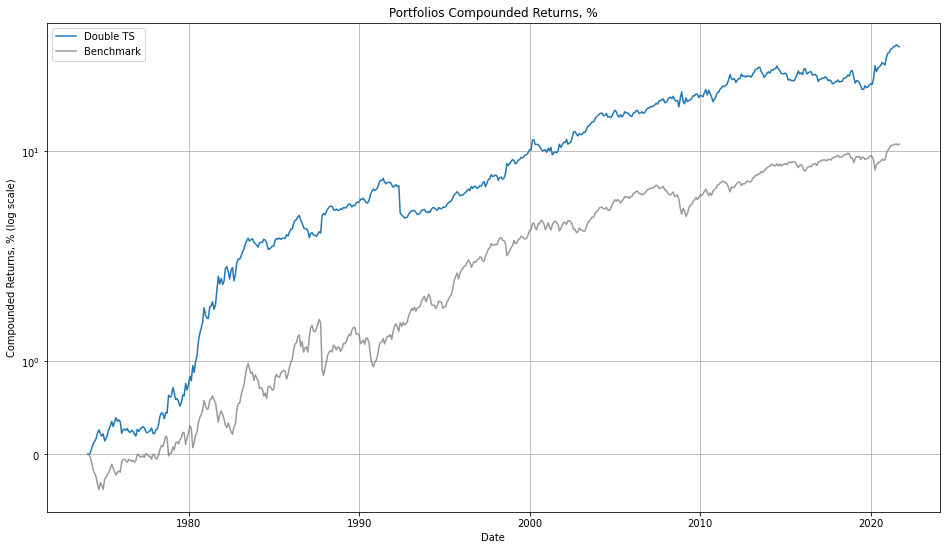

In [11]:
summary([double_ts_portfolio])

Использование методики double time-series momentum действительно показало себя лучше простого моментума за счет тайминга, но есть подозрение, что с введением ограничения на шорты и комиссий, это уйдет, и получится либо такой же моментум, либо даже чуть хуже.